In [ ]:
import numpy as np
np.seterr(all='ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from my_functions import *
from load_mocks import ensemble_mock

In [ ]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))
w_lya = 1215.67
filter_tags = load_filter_tags()

In [ ]:
name_qso = 'QSO_100000_0'
name_gal = 'GAL_100000_0'
name_sf = 'LAE_10deg_z2-4.25_0'

pm_flx, pm_err, zspec, EW_lya, L_lya, is_qso, is_sf, is_gal =\
    ensemble_mock(name_qso, name_gal, name_sf)

In [ ]:
mag = flux_to_mag(pm_flx[-2], w_central[-2])
mag[np.isnan(mag)] = 99.

N_sources = pm_flx.shape[1]
N_sources

In [ ]:
ew0_cut = 30
ew_other = 100

# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err, IGM_T_correct=True)
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, ew0_cut)
lya_lines, lya_cont_lines, line_widths = identify_lines(
    line, pm_flx, cont_est_lya, first=True, return_line_width=True
)
lya_lines = np.array(lya_lines)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    ew_other, obs=True)
other_lines = identify_lines(line_other, cont_est_other, pm_err)

# Compute z
z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

nice_z = np.abs(z_Arr - zspec) < 0.16

# %xdel cont_est_other
%xdel cont_err_other

In [ ]:
mag_min = 17
mag_max = 24

nb_min = 5
nb_max = 15
# nb_min = 16
# nb_max = 23

# Used later!!
L_min = 40
L_max = 50

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5) / w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5) / w_lya - 1
print(f'z interval: ({z_min:0.2f}, {z_max:0.2f})')

z_cut = (z_min < z_Arr) & (z_Arr < z_max)
zspec_cut = (z_min < zspec) & (zspec < z_max)
ew_cut = EW_lya > ew0_cut
mag_cut = (mag > mag_min) & (mag < mag_max)

nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr
)
nice_lya = (nice_lya & z_cut & mag_cut)

In [ ]:
EW_nb_Arr, EW_nb_e, L_Arr, L_e_Arr, flambda, flambda_e = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, N_nb=0
)

ML_predict_mask = (mag < 23) & (L_Arr > 0)
L_Arr[ML_predict_mask] = ML_predict_L(
    pm_flx[:, ML_predict_mask], pm_err[:, ML_predict_mask],
    z_Arr[ML_predict_mask], L_Arr[ML_predict_mask], 'RFmag15-23'
)

ML_predict_mask = (mag > 23) & (L_Arr > 0)
L_Arr[ML_predict_mask] = ML_predict_L(
    pm_flx[:, ML_predict_mask], pm_err[:, ML_predict_mask],
    z_Arr[ML_predict_mask], L_Arr[ML_predict_mask], 'RFmag23-23.5'
)

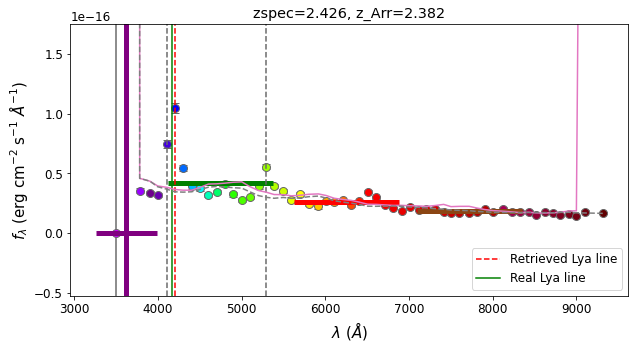

In [9]:
selected = np.random.permutation(
    np.where(
        ~nice_lya & (L_Arr > 44.5) & mag_cut & (EW_lya > 30) & zspec_cut
        # nice_lya & is_gal
    )[0]
)
print(count_true(selected))

for i, src in enumerate(selected):
    if i == 10: break
    print(f'L_lya = {L_lya[src]}')
    print(f'L_Arr = {L_Arr[src]}')
    print(f'EW0 = {EW_lya[src]}')
    print(is_qso[src])

    lya_obs_w = w_central[lya_lines[src]]
    other_lines_w = [w_central[i] for i in other_lines[src]]
    lya_real_w = w_lya * (1 + zspec[src])

    fig = plt.figure(figsize=(10, 5))
    ax = plot_JPAS_source(pm_flx[:, src], pm_err[:, src])

    ax.axvline(lya_obs_w, linestyle='--', color='r', label='Retrieved Lya line')
    ax.axvline(lya_real_w, color='g', label='Real Lya line')
    for w in other_lines_w:
        ax.axvline(w, linestyle='--', color='dimgray')
    print(other_lines[src])

    ax.plot(w_central[:56], cont_est_lya[:, src])
    ax.plot(w_central[:56], cont_est_other[:, src], ls='--')

    ax.set_title(f'zspec={zspec[src]:0.3f}, z_Arr={z_Arr[src]:0.3f}')
    ax.legend()

    # ax.set_ylim((-1e-17, 1e-17))

    plt.show()